In [156]:
from typing import TypedDict

import requests
from bs4 import BeautifulSoup
from langchain.chat_models import init_chat_model
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.messages import ToolMessage
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter
import os , getpass

from pydantic import BaseModel, Field
from langchain_core.tools import tool, create_retriever_tool
from langgraph.graph import StateGraph, START, END,add_messages
from typing import Annotated

In [24]:
url = "https://www.nationalgeographic.com/health/article/beach-ocean-mental-health-benefits"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

# Lấy toàn bộ text (nội dung hiển thị trên trình duyệt, bỏ tag HTML)
paragraphs = soup.find_all("p")
for p in paragraphs:
    print(p.get_text())

Visiting the coast can help you relieve stress and get more active—and it may even change the way you cope with pain.
The coast has long been a place of healing. In 18th-century Europe, doctors prescribed beach time for ailments ranging from tuberculosis to leprosy. Patients spent their days bathing in (and often drinking) mineral-rich sea water, and at night, they fell asleep to the sounds of briny winds and crashing waves.
While elements of this early sea therapy have since been disproven, modern science continues to find that nature is good for us. Researchers got an early inkling of this in a landmark 1984 study that showed post-op patients whose hospital rooms had views of natural spaces tended to have shorter and more pleasant stays than those whose rooms faced a brick wall.
(14 iconic beaches you should visit in your lifetime.)
In the decades since, the field of environmental psychology has investigated why humans are hardwired to feel better outdoors. Most of their work has foc

In [25]:
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)

In [26]:
# Get text data from paragraphs
chunks = [p.get_text() for p in paragraphs]
chunks

['Visiting the coast can help you relieve stress and get more active—and it may even change the way you cope with pain.',
 'The coast has long been a place of healing. In 18th-century Europe, doctors prescribed beach time for ailments ranging from tuberculosis to leprosy. Patients spent their days bathing in (and often drinking) mineral-rich sea water, and at night, they fell asleep to the sounds of briny winds and crashing waves.',
 'While elements of this early sea therapy have since been disproven, modern science continues to find that nature is good for us. Researchers got an early inkling of this in a landmark 1984 study that showed post-op patients whose hospital rooms had views of natural spaces tended to have shorter and more pleasant stays than those whose rooms faced a brick wall.',
 '(14 iconic beaches you should visit in your lifetime.)',
 'In the decades since, the field of environmental psychology has investigated why humans are hardwired to feel better outdoors. Most of 

In [27]:
docs = [Document(page_content=chunk) for chunk in chunks]
docs

[Document(metadata={}, page_content='Visiting the coast can help you relieve stress and get more active—and it may even change the way you cope with pain.'),
 Document(metadata={}, page_content='The coast has long been a place of healing. In 18th-century Europe, doctors prescribed beach time for ailments ranging from tuberculosis to leprosy. Patients spent their days bathing in (and often drinking) mineral-rich sea water, and at night, they fell asleep to the sounds of briny winds and crashing waves.'),
 Document(metadata={}, page_content='While elements of this early sea therapy have since been disproven, modern science continues to find that nature is good for us. Researchers got an early inkling of this in a landmark 1984 study that showed post-op patients whose hospital rooms had views of natural spaces tended to have shorter and more pleasant stays than those whose rooms faced a brick wall.'),
 Document(metadata={}, page_content='(14 iconic beaches you should visit in your lifetim

In [28]:
split_docs = text_splitter.split_documents(docs)
split_docs

[Document(metadata={}, page_content='Visiting the coast can help you relieve stress and get more active—and it may even change the way you cope with pain.'),
 Document(metadata={}, page_content='The coast has long been a place of healing. In 18th-century Europe, doctors prescribed beach time for ailments ranging from tuberculosis to leprosy. Patients spent their days bathing in (and often drinking) mineral-rich sea water, and at night, they fell asleep to the sounds of briny winds and crashing waves.'),
 Document(metadata={}, page_content='While elements of this early sea therapy have since been disproven, modern science continues to find that nature is good for us. Researchers got an early inkling of this in a landmark 1984 study that showed post-op patients whose hospital rooms had views of natural spaces tended to have shorter and more pleasant stays than those whose rooms faced a brick wall.'),
 Document(metadata={}, page_content='(14 iconic beaches you should visit in your lifetim

In [29]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [32]:
# Initialize embeddings model
embeddings = OpenAIEmbeddings()

# Create and persist vector store
vectorstore = Chroma.from_documents(
    documents=split_docs,
    embedding=embeddings,
    persist_directory="learning_db"
)

In [47]:
retrieve_docs_tool = create_retriever_tool(vectorstore.as_retriever(), "retrieve_question_source_material", "Retrieve content from the internal document used as source material to generate exam questions.")

In [226]:
class GenerateTestPromptInput(BaseModel):
    """Input schema for generating a test prompt"""
    level: str = Field(..., description="Test level: easy , medium or hard. Only three levels are available.")
    type_question: str = Field(..., description="Question type: multiple choice  or fill in the blank.")
    total: str = Field(..., description="Total number of questions.")
    topic: str = Field(..., description="Topic of the test.")

@tool("generate_test_prompt", args_schema=GenerateTestPromptInput)
def generate_test_prompt(level: str, type_question: str, total: str, topic: str) -> str:
    """
    Generates a prompt describing the test creation requirements based on the level and type of input questions.
    """
    prompt_templates = f"""Generate a {type_question} test with topic is {topic} based on the provided document with {total} questions..
    Difficulty: {level}, suitable for beginners.
    Question types should be diverse, including:
        Single correct answer,
        Multiple correct answers,
        All are correct,
        None are correct,
        Affirmative and negative statements.
    Ensure that all questions are relevant to the document, clearly phrased, and not misleading.
"""
    return prompt_templates

In [267]:
class LearningState(TypedDict):
    messages: Annotated[list, add_messages]
    revert_prompt: str


learning_graph = StateGraph(LearningState)

In [254]:
llm_model = init_chat_model("openai:gpt-4o-mini", temperature=0)

In [255]:
llm_generate_prompt = llm_model.bind_tools([generate_test_prompt])
llm_generate_documents = llm_model.bind_tools([retrieve_docs_tool])

In [256]:
def chat_bot_generate_prompt(state: LearningState):
    print("chat_bot_generate_prompt")
    system_message = {
        "role": "system",
        "content":"""You are an intelligent assistant who is only allowed to answer a question if you can use one of the defined tools. If none of the tools match the question, answer verbatim:

The question is outside the scope of information I am authorized to access.
Never infer or make up an answer without the appropriate tool."""
    }
    response_llm = (
        llm_generate_prompt.invoke([system_message] + state["messages"])
    )
    return {"messages": response_llm}

In [257]:
def run_tool_generate_prompt(state: LearningState):
    print("run_tool_generate_prompt")
    last_message = state["messages"][-1]
    revert_prompt = ''
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        results = []
        # Process each tool call
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == "generate_test_prompt":
                tool_result = generate_test_prompt.invoke(tool_call['args'])
                revert_prompt = tool_result
                results.append(ToolMessage(content=tool_result, name="generate_test_prompt",tool_call_id=tool_call['id']))

        return {"messages": results , "revert_prompt": revert_prompt}
    return {"messages": []}


In [258]:
def route_tool(state: LearningState):
    print("route_tool")
    last_message = state["messages"][-1]
    if hasattr(last_message , "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return END


In [259]:
def get_context_or_response(state: LearningState):
    print("get_context_or_response")
    system_message = [
         {
            "role": "system",
        "content":"""Only create a quiz if the question content is within the scope of the provided documentation.
If the topic requesting the quiz is not within the documentation, please respond verbatim with the following:
The document requesting the quiz is not within the scope of the allowed documentation.
Do not speculate or create content that is not within the documentation."""
        }
    ]

    response_llm = (
        llm_generate_documents.invoke(system_message + state["messages"])
    )
    return {"messages": response_llm}

In [260]:
def route_documents(state: LearningState):
    print("route_documents")
    last_message = state["messages"][-1]
    if hasattr(last_message , "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return END

In [261]:
def run_tool_generate_examination(state: LearningState):
    print("run_tool_generate_examination")
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        results = []
        # Process each tool call
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == "retrieve_question_source_material":
                tool_result = retrieve_docs_tool.invoke({"query": tool_call["args"].get("query", "")})
                results.append(ToolMessage(content=tool_result, name="retrieve_question_source_material",tool_call_id=tool_call['id']))

        return {"messages": results}
    return {"messages": []}


In [266]:
def generating_examination(state: LearningState):
    generating_examination_prompt = """The returned result must be in JSON format with the following structure:\n
question_data: list of questions, each element is an object containing:\n
question: question content,type_question: question type, only accepts one of two values:
"multi_choice" if it is a multiple choice question,
"fill_in_blank" if it is a fill-in-the-blank question,
type_answer: answer type, only accepts one of the following values:\n
"single_correct": only 1 correct answer,
"multi_correct": multiple correct answers,
"all_correct": all answers are correct,
"none_correct": all answers are incorrect,
answers_data: array of answers, each element has:\n
content: content of the answer,
is_correct: true if the answer is correct, false if the answer is incorrect.\n
Question: {question}\n
Context: {context}"""
    revert_prompt = state["revert_prompt"]
    context = state["messages"][-1].content
    prompt = generating_examination_prompt.format(question=revert_prompt,context=context)
    response_examination = llm_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": response_examination}


In [268]:
learning_graph.add_node("chat_bot_generate_prompt",chat_bot_generate_prompt)
learning_graph.add_node("run_tool_generate_prompt",run_tool_generate_prompt)
learning_graph.add_node("get_context_or_response",get_context_or_response)
learning_graph.add_node("retriever_tools",run_tool_generate_examination)
learning_graph.add_node("generating_examination",generating_examination)
learning_graph.add_edge(START, "chat_bot_generate_prompt")
learning_graph.add_conditional_edges("chat_bot_generate_prompt",route_tool,{
    "tools":"run_tool_generate_prompt"  ,
    END:END
} )
learning_graph.add_edge("run_tool_generate_prompt","get_context_or_response")
learning_graph.add_conditional_edges("get_context_or_response",route_documents,{
    "tools":"retriever_tools",
    END:END
})
learning_graph.add_edge("retriever_tools","generating_examination")
graph = learning_graph.compile()

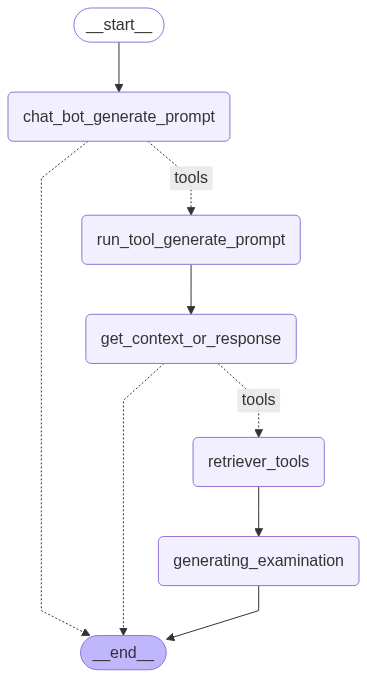

In [269]:
graph

In [270]:
response = graph.invoke({
    "messages":"""I want to create an easy multiple choice test with 10 questions on the topic "Health benefits of going to the beach" """
})
response["messages"][-1].content


chat_bot_generate_prompt
route_tool
run_tool_generate_prompt
get_context_or_response
route_documents
run_tool_generate_examination


'```json\n{\n  "question_data": [\n    {\n      "question": "What is one of the benefits of visiting the beach?",\n      "type_question": "multi_choice",\n      "type_answer": "single_correct",\n      "answers_data": [\n        {\n          "content": "It helps relieve stress.",\n          "is_correct": true\n        },\n        {\n          "content": "It guarantees a cure for all ailments.",\n          "is_correct": false\n        },\n        {\n          "content": "It has no effect on mental health.",\n          "is_correct": false\n        },\n        {\n          "content": "It makes you more sedentary.",\n          "is_correct": false\n        }\n      ]\n    },\n    {\n      "question": "Which activities can you do at the beach to become more active?",\n      "type_question": "multi_choice",\n      "type_answer": "multi_correct",\n      "answers_data": [\n        {\n          "content": "Swimming",\n          "is_correct": true\n        },\n        {\n          "content": "Sitt

In [271]:
def format_and_save_json(json_string, filename="learning.json"):
    """
    Format a JSON string by removing ```json prefix and ``` suffix,
    and save it to a file.

    Args:
        json_string (str): The JSON string to format
        filename (str): The name of the file to save the formatted JSON to
    """
    # Remove ```json prefix and ``` suffix if they exist
    if json_string.startswith("```json"):
        json_string = json_string[7:]  # Remove ```json
    elif json_string.startswith("```"):
        json_string = json_string[3:]  # Remove ```

    if json_string.endswith("```"):
        json_string = json_string[:-3]  # Remove ```

    # Strip any leading/trailing whitespace
    json_string = json_string.strip()

    # Save to file
    with open(filename, "w") as f:
        f.write(json_string)

    print(f"JSON saved to {filename}")
    return json_string

# Format and save the JSON


In [272]:
formatted_json = format_and_save_json(response["messages"][-1].content)

JSON saved to learning.json
